## Case Study 

# Maximise the total profit earned by the driver of SuperCabs in a Day

### Objective:
**To build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.**



In [1]:
#Importing Libraries
from Env import CabDriver

import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import math
import random

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

%matplotlib inline

### 1. Load the Time Matrix

In [2]:
TIME_MATRIX_PATH = "TM.npy"

In [3]:
# Load the time matrix 
Time_matrix = np.load(TIME_MATRIX_PATH)

In [4]:
# check the max, min and mean time values to help us in defining the 'next_step' function in the Environment

print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


**Since the max time is 11 hours between any 2 points, the next state of the cab driver can only change by  1 day**

### 2. Defining Agent Class

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify the hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()
        
        
    # Create a neural-network model approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_normal'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate, ))
        model.summary
        return model

    
    
    # Define epsilon-greedy strategy
    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]
        
        

    # append the recent experience tuple <state, action, reward, new-state> to the memory
    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
        
        
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    """
    >>> If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per 
    the mini-batch size and do the following:
              > Initialise your input and output batch for training the model
              > Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
              > Get Q(s', a) values from the last trained model
              > Update the input batch as your encoded state and output batch as your Q-values
              > Then fit your DQN model using the updated input and output batch.
    """
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
            
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state 
        q_value = self.model.predict(self.track_state)
        
        print(f"States_tracked value {q_value[0][2]}.")
        
        # Grab the q_value of the action index 
        self.states_tracked.append(q_value[0][2])
        
    def save(self, name):
        self.model.save(name)

### 3. DQN block

In [6]:
episode_time = 24*30        #30 days before which car has to be recharged
n_episodes = 500
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

C:\Users\sonia\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


**Note:**
- The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory
- The init state is randomly picked from the state space for each episode

In [7]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    # Total time driver rode in this episode
    total_time = 0  
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipulated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print(f"episode {episode}, reward {score}, memory_length {len(agent.memory)}, epsilon {agent.epsilon} total_time {total_time}")
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print(f"Saving Model {episode}")
        agent.save(name="taxi_model.h5")

    
elapsed_time = time.time() - start_time
print(elapsed_time)


Saving Model 0
States_tracked value 0.0.
episode 9, reward -304.0, memory_length 1384, epsilon 0.9955001547284723 total_time 721.0
States_tracked value 0.0.
States_tracked value 0.0.
episode 19, reward -227.0, memory_length 2000, epsilon 0.9905350769930761 total_time 723.0
States_tracked value 0.0.
States_tracked value 0.0.
episode 29, reward -278.0, memory_length 2000, epsilon 0.9855947626861951 total_time 729.0
States_tracked value 0.0.
States_tracked value 0.0.
episode 39, reward -210.0, memory_length 2000, epsilon 0.9806790882997144 total_time 725.0
States_tracked value 0.0.
States_tracked value 0.0.
episode 49, reward -13.0, memory_length 2000, epsilon 0.9757879309415182 total_time 726.0
States_tracked value 0.0.
States_tracked value 0.0.
episode 59, reward -13.0, memory_length 2000, epsilon 0.9709211683324178 total_time 738.0
States_tracked value 0.0.
States_tracked value 0.0.
episode 69, reward -40.0, memory_length 2000, epsilon 0.9660786788030947 total_time 726.0
States_tracked

**The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720**

In [8]:
# Saving the tracked states
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
save_obj(agent.states_tracked,"model_weights")

### Tracking Convergence

In [10]:
agent.states_tracked

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 561.64874,
 588.5735,
 614.8021,
 794.25397,
 699.67664,
 534.179,
 476.38815,
 561.3652,
 590.96246,
 629.8786,
 558.8483,
 627.5909,
 627.02423,
 478.60205,
 576.4138,
 465.72595,
 677.4983]

In [11]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### 5. Plot the Q-Value convergence for state action pairs

In [24]:
plt.style.use('seaborn')
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Using log scale, since the initial q_values are way too high compared to the steady state value

### 6. Track rewards per episode.

In [13]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

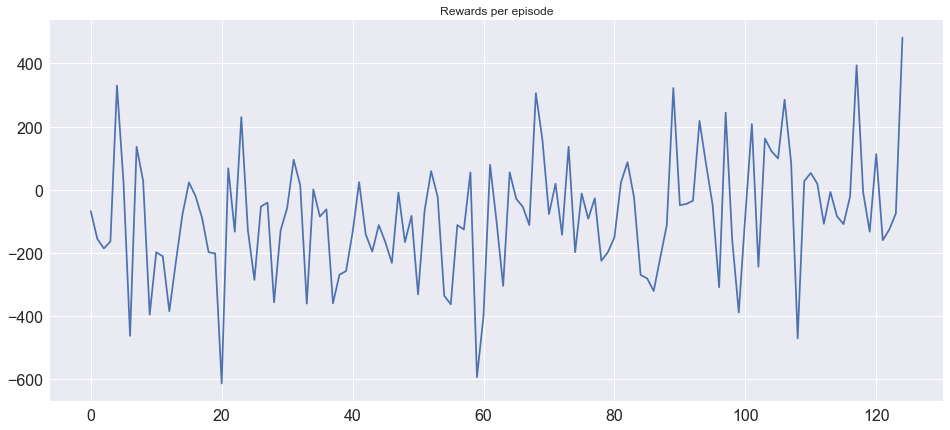

In [14]:
plt.style.use('seaborn')
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

We can see from the above plot that the rewards converge at around 500. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function: building a similar epsilon-decay plot

In [17]:
import numpy as np
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

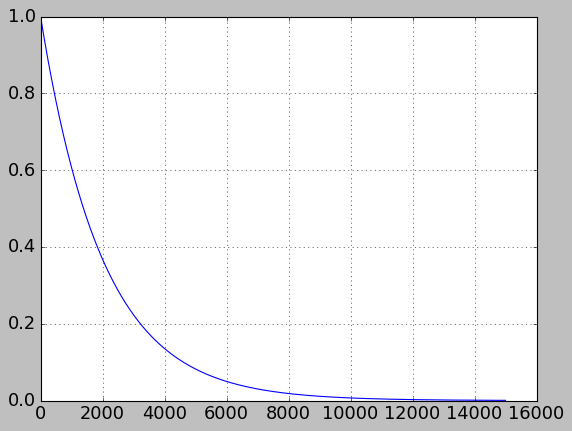

In [18]:
plt.style.use('classic')
plt.plot(time, epsilon)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()